In [1]:
import pandas as pd
import xarray as xr
import xsimlab as xs
import episimlab as esl
from episimlab.models.basic import toy_partition

# 20210203_test_kp_migration

The purpose of this notebook is to test/demo a "Frankenstein" model that combines Kelly P.'s phi computation workflow (partitioning contacts) with the 16-compartment SEIR model that ships with Episimlab.

We are, in essence, recapitulating pytest class `TestSixteenComptToy` in `tests/test_partition.py`. The model takes one of the default models in Episimlab (`cy_seir_cy_foi` from `src/episimlab/models/basic.py`), and modifies it with processes from `src/episimlab/partition/toy.py`.

A brief summary of the processes that were added to implement deviation from the `cy_seir_cy_foi` model:
* `SetupPhiWithPartitioning` implements `partition_contacts` from `SEIR_example.seir.SEIR`
* `SetupCounts` replaces (actually subclasses) `InitDefaultCounts`, instantiating the big xarray called `counts` that contains the population of each compartment at a given time point.
* Likewise, `InitCoords` subclasses `InitDefaultCoords` and instantiates coordinate sets for above mentioned `counts` based on the values in the config (`n_nodes` and `n_age`). These coords are also used for some epi parameters, such as gamma, pi, nu, etc.
* `ReadToyPartitionConfig` replaces `ReadV1Config`. It reads a YAML file at input variable `config_fp` and "sends" the read variables to different processes throughout the model.

In [2]:
model = toy_partition()

Convenience function that wraps xsimlab.run:

In [3]:
def run_model(model, step_clock, input_vars, output_vars):
    input_ds = xs.create_setup(
        model=model,
        clocks=step_clock,
        input_vars=input_vars,
        output_vars=output_vars
    )
    return input_ds.xsimlab.run(model=model, decoding=dict(mask_and_scale=False))

In [9]:
config_fp = '../tests/data/partition_capture/test_config0.yaml'
input_vars = {
    'read_config__config_fp': config_fp,
    'rng__seed_entropy': 12345,
    'sto__sto_toggle': -1,
    'setup_coords__n_age': 2,
    'setup_coords__n_nodes': 2,
    'setup_coords__n_risk': 1,
    'setup_phi__travel_fp': '../tests/data/partition_capture/travel0.csv',
    'setup_phi__contacts_fp': '../tests/data/partition_capture/contacts0.csv'
}
output_vars = {
    'apply_counts_delta__counts': 'step',
    'setup_phi__phi_t': 'step'
}
step_clock = {
    'step': pd.date_range(
        start='1/1/2018', end='1/15/2018', freq='2H'
    )
}

result = run_model(model, step_clock, input_vars, output_vars)
assert isinstance(result, xr.Dataset)

/Users/TASethanho/tacc/projects/meyers/covid/episimlab/src/episimlab/setup/epi/base.py:43: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return data.__getitem__(slices)


In [10]:
result

<xarray.Dataset>
Dimensions:                     (age_group: 2, compartment: 16, phi_grp1: 4, phi_grp2: 4, risk_group: 1, step: 169, vertex: 2)
Coordinates:
  * age_group                   (age_group) <U5 'young' 'old'
  * compartment                 (compartment) <U5 'S' 'E' 'Pa' ... 'Iy2Ih' 'H2D'
  * phi_grp1                    (phi_grp1) int64 1 0 3 2
  * phi_grp2                    (phi_grp2) int64 1 0 3 2
  * risk_group                  (risk_group) int64 0
  * step                        (step) datetime64[ns] 2018-01-01 ... 2018-01-15
  * vertex                      (vertex) <U1 'A' 'B'
Data variables:
    apply_counts_delta__counts  (step, vertex, age_group, risk_group, compartment) float64 ...
    read_config__config_fp      <U49 '../tests/data/partition_capture/test_co...
    rng__seed_entropy           int64 12345
    setup_coords__n_age         int64 2
    setup_coords__n_nodes       int64 2
    setup_coords__n_risk        int64 1
    setup_phi__contacts_fp      <U45 '../tests/data/partition_capture/contact...
    setup_phi__phi_t            (step, phi_grp1, phi_grp2) float64 0.0 ... 0.0
    setup_phi__travel_fp        <U43 '../tests/data/partition_capture/travel0...
    sto__sto_toggle             int64 -1

## Plotting

Let's try plotting these results:

In [6]:
def xr_viz(data_array, sel=dict(), isel=dict(),
           timeslice=slice(0, None),
           sum_over=['risk_group', 'age_group']):
    """Uses DataArray.plot, which builds on mpl
    """
    assert isinstance(data_array, xr.DataArray)
    isel.update({'step': timeslice})
    da = data_array[isel].loc[sel].sum(dim=sum_over)
    _ = da.plot.line(x='step', aspect=2, size=7)

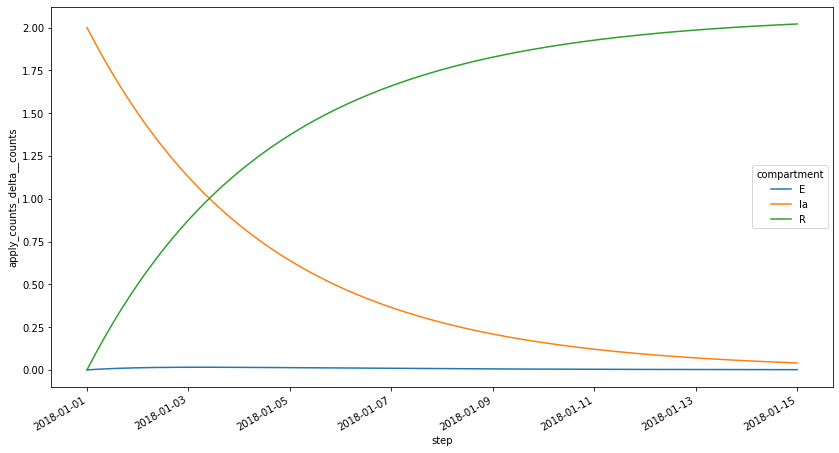

In [7]:
xr_viz(result['apply_counts_delta__counts'], sum_over=['age_group', 'risk_group', 'vertex'], sel=dict(compartment=['E', 'Ia', 'R']))

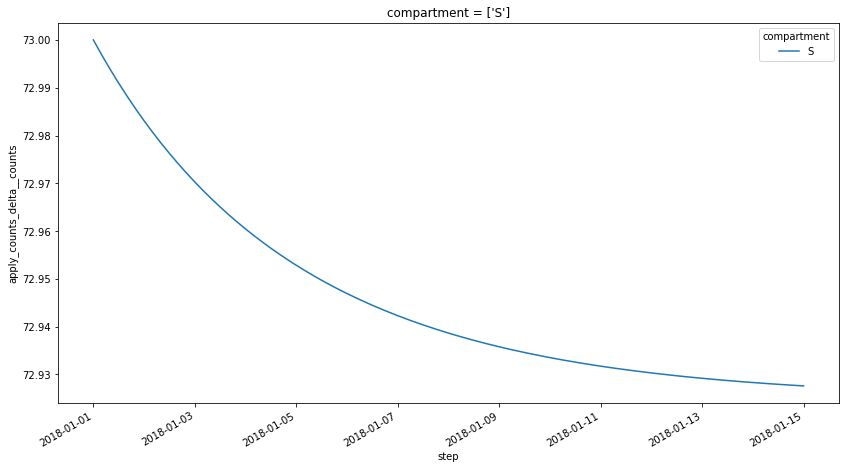

In [8]:
xr_viz(result['apply_counts_delta__counts'], sum_over=['age_group', 'risk_group', 'vertex'], sel=dict(compartment=['S']))